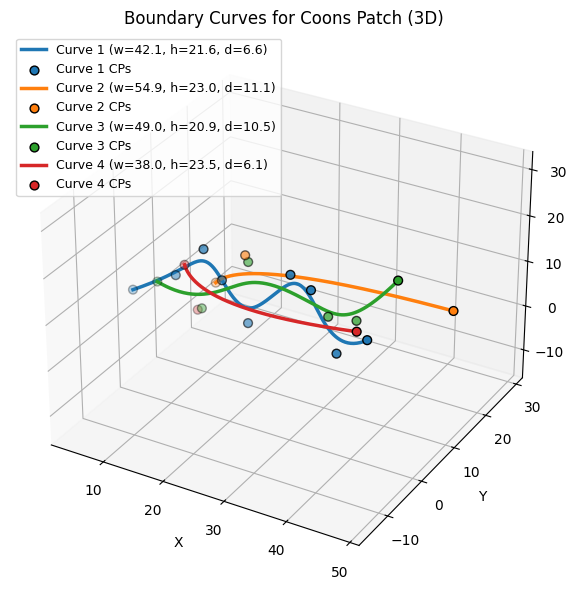

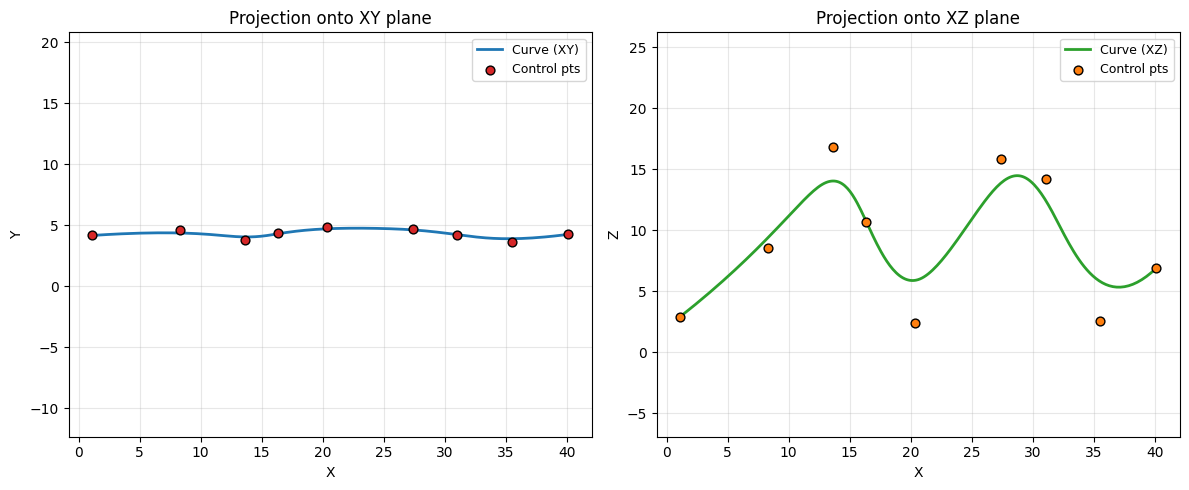

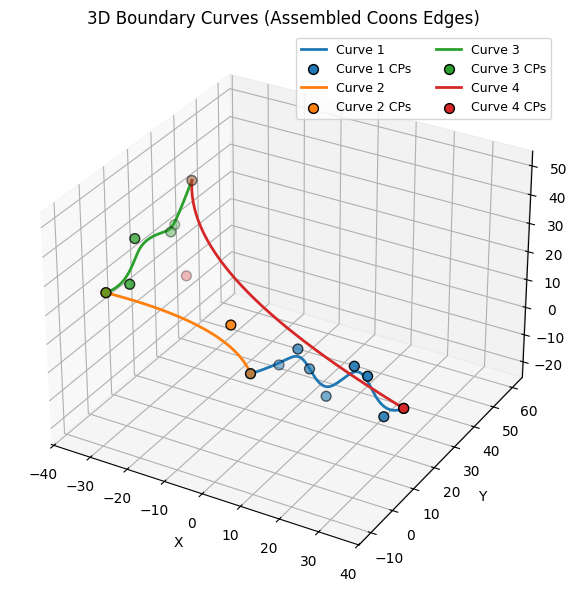

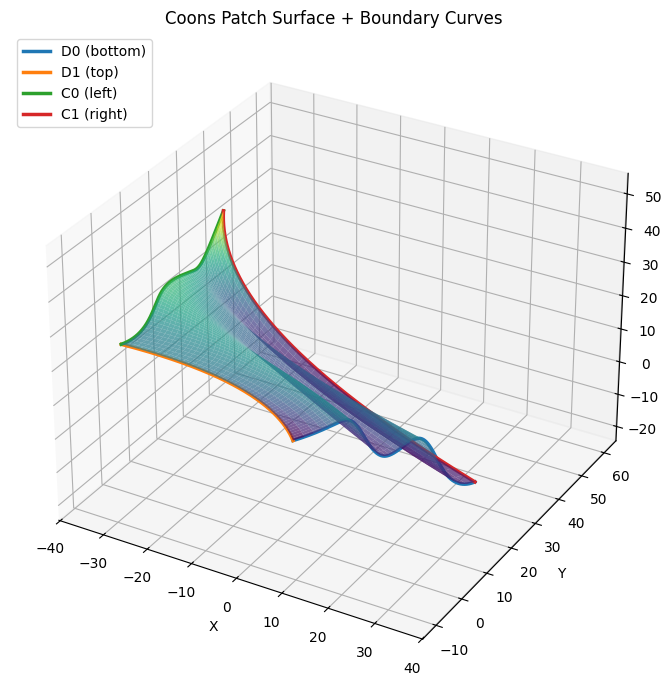

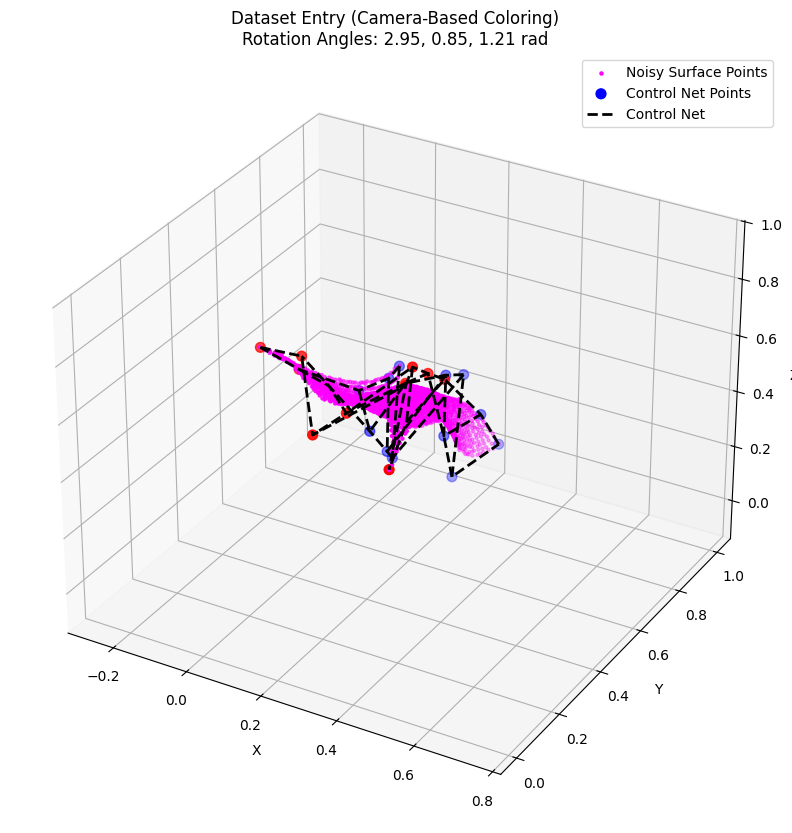

Created a dataset entry.
Rotation angles (radians): (np.float64(2.9505754013125784), np.float64(0.8545784674448739), np.float64(1.2100051664972127))
Z-gap between curves: None


In [5]:
import numpy as np
import DatasetGeneratorKoons  # assuming your module is named DatasetGenerator.py

angle_ranges_deg = {
            'x': (-45, 45),
            'y': (-45, 45),
            'z': (-10, 10)
        }

angle_ranges_deg = {
            'x': (-90, 90),
            'y': (90, 90),
            'z': (-25, 25)
        }


# Create a single dataset entry using the new parameter list:
entry = DatasetGeneratorKoons.create_dataset_entry(
    # -------------- curve layout ---------------------------------
    num_points_range      =(3, 10),     # control-points per edge curve
    plane_width_range     =(30, 60),
    plane_height_range    =(15, 30),
    plane_depth_range     =(5, 15), # 5 15

    # -------------- surface-grid resolution ----------------------
    num_samples           = 50,         # points in u-direction (≈ “width”)
    num_v                 = 50,         # points in v-direction (≈ “height”)

    # -------------- NURBS fitting --------------------------------
    degree_u              = 3,
    degree_v              = 3,
    ctrlpts_size_u_range  =(4, 6),
    ctrlpts_size_v_range  =(4, 6),

    # -------------- augmentation ---------------------------------
    noise_std             = 0.1,
    noise_mean            = 0.0,
    random_rotation       = True,
    
    angle_ranges_deg = angle_ranges_deg,


    # -------------- normalise / resample for NN ------------------
    normalize             = True,       # scale to unit box
    resample              = False,      # keep the 35×35 grid as-is
    target_shape          =(50, 50, 3), # ignored if resample=False

    # -------------- visualisation --------------------------------
    show_visu             = True
)

print("Created a dataset entry.")
print("Rotation angles (radians):", entry["rotation_angle"])
print("Z-gap between curves:", entry["z_gap"])






[[[[0.10499845 0.7200942  0.45503914]
   [0.10642378 0.7089583  0.42039546]
   [0.10922543 0.7076867  0.3926998 ]
   ...
   [0.2130574  0.96364135 0.02532979]
   [0.21930434 0.9770399  0.02366047]
   [0.22223778 1.         0.02735058]]

  [[0.10505309 0.70972866 0.4525595 ]
   [0.10784662 0.7042348  0.42227954]
   [0.10927833 0.70073366 0.39012676]
   ...
   [0.22012141 0.93924236 0.05432564]
   [0.22632828 0.9572805  0.05799284]
   [0.23186041 0.9693782  0.05907465]]

  [[0.10502919 0.7055341  0.45475963]
   [0.10909185 0.6949255  0.42172495]
   [0.10839633 0.69362366 0.39580464]
   ...
   [0.22744258 0.91523474 0.08714695]
   [0.2304938  0.93256974 0.08841053]
   [0.23635694 0.9499449  0.09203824]]

  ...

  [[0.01087364 0.29293826 0.739573  ]
   [0.02474578 0.2919244  0.74248224]
   [0.03739353 0.2871029  0.7443844 ]
   ...
   [0.47362006 0.07047921 0.75822884]
   [0.48192924 0.05093347 0.7478632 ]
   [0.48674795 0.03050466 0.73376966]]

  [[0.00670063 0.28022972 0.75591326]
   [0.0

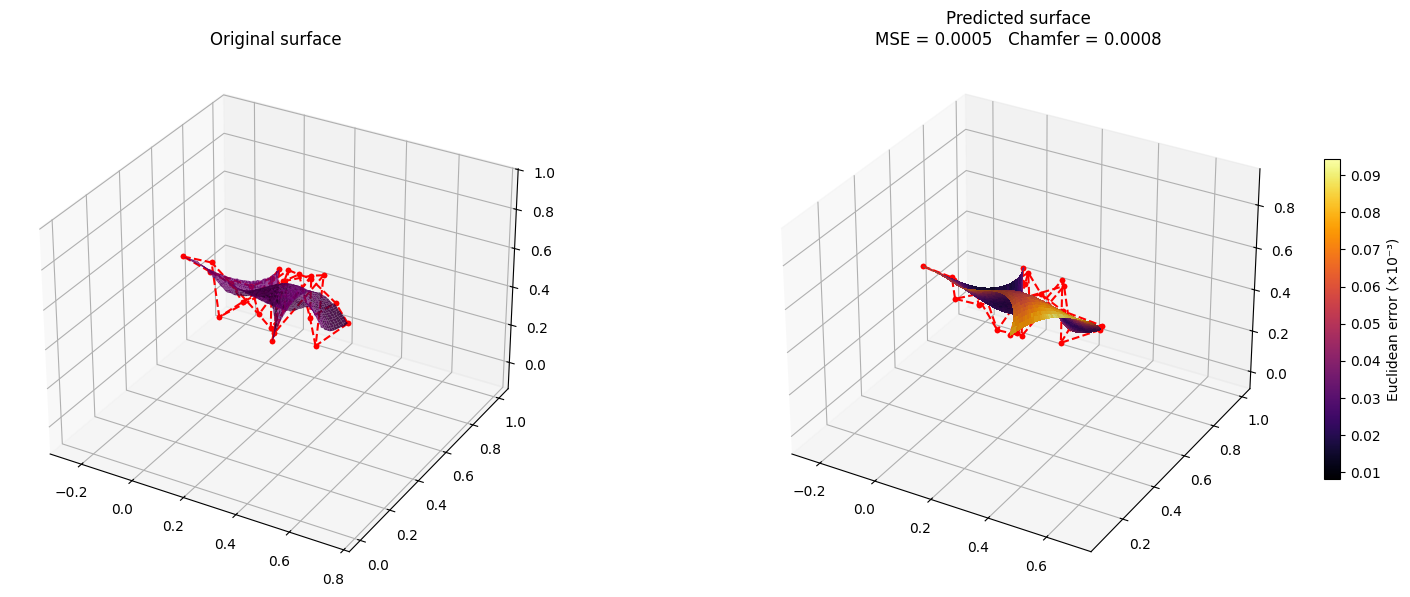

|   mse_surface |   chamfer_surface |   mse_ctrl_net |   chamfer_ctrl_net |
|--------------:|------------------:|---------------:|-------------------:|
|      0.000502 |          0.000841 |       0.001273 |           0.007074 |
Control‑net shapes (u×v): orig=(5, 5), pred=(5, 5), approx=(5, 5)
MSE  – Predicted vs Original    : 0.001273
MSE  – Approximated vs Original : 0.000113
Chamfer – Predicted vs Original    : 0.007074
Chamfer – Approximated vs Original : 0.000678


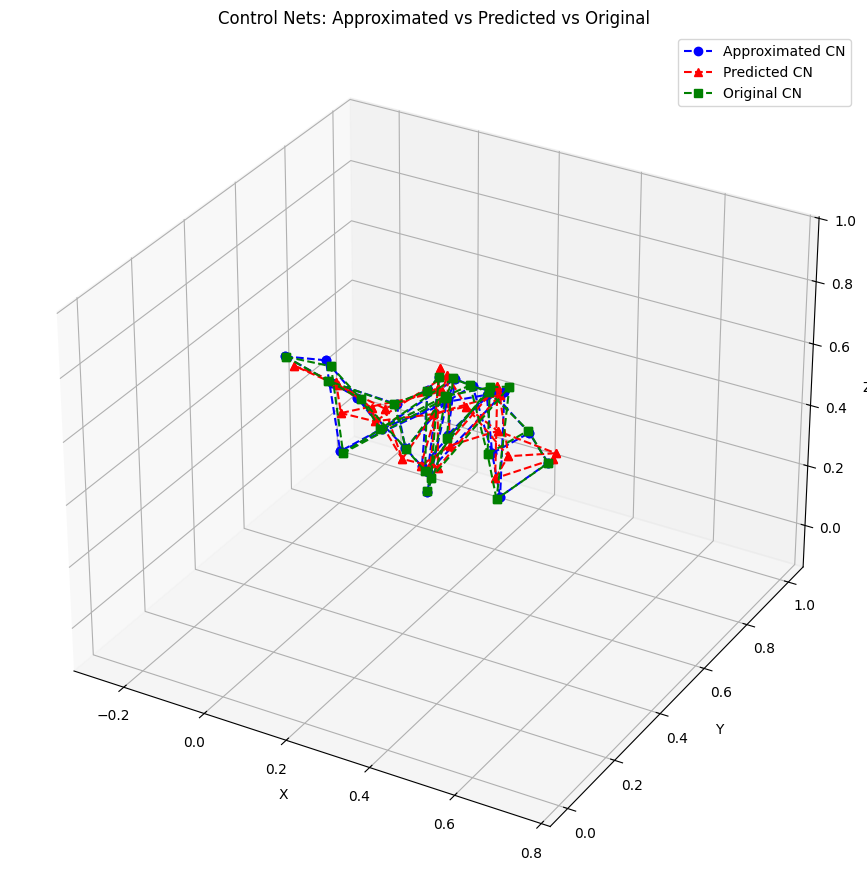

{'mse_predicted': 0.0012732789618894458,
 'mse_approx': 0.00011301130692455322,
 'chamfer_predicted': 0.007073739872529804,
 'chamfer_approx': 0.0006780678415473193}

In [6]:


from tensorflow.keras.utils import register_keras_serializable


def laplacian(grid):
    """
    grid : (B, H, W, C) tensor – C = 3 for (x,y,z)
    returns channel-wise 4-neighbour Laplacian with SAME shape.
    """
    lap_k = tf.constant([[0, 1, 0],
                         [1, -4, 1],
                         [0, 1, 0]], tf.float32)  # (3,3)
    lap_k = lap_k[..., tf.newaxis, tf.newaxis]  # (3,3,1,1)

    C = tf.shape(grid)[-1]  # channel count at run-time
    lap_k = tf.tile(lap_k, [1, 1, C, 1])  # (3,3,C,1)

    return tf.nn.depthwise_conv2d(grid, lap_k,
                                  strides=[1, 1, 1, 1],
                                  padding='SAME')  # (B,H,W,C)


# ─────────────────────────────────────────────────────────────────────

@register_keras_serializable(package='CustomLosses', name='total_loss')
def total_loss(y_true, y_pred, w_lap=0.05):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    lap = tf.reduce_mean(tf.square(laplacian(y_true) - laplacian(y_pred)))
    return mse + w_lap * lap














#dataset_file = "dataset/dataset_10_surfaces_noise0.1_2605_2032.pkl"



import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# Import necessary packages and the compare library
import pickle
import numpy as np
import matplotlib.pyplot as plt
import surface_compare_coons
import tensorflow as tf

# Load a sample dataset entry (assumed to be saved as a pickle file)
# Replace 'sample_entry.pkl' with your actual dataset entry file path.

# Import the non-visualization and visualization libraries
import DatasetGenerator
import nurbs_vis
import pickle
import pandas as pd


entry2 = entry
# Load the dataset from file.
#with open(dataset_file, "rb") as f:
#    entry = pickle.load(f)

# Visualize the first dataset entry from the loaded dataset.
#nurbs_vis.visualize_dataset_entry(entry[49])

#  models/coons_surface_incept_20251006_0334_30ep.keras

# Load the trained model from the provided file

#model = tf.keras.models.load_model("models/coons_surface_incept_20250906_1951_150ep.keras",
#                   custom_objects={'total_loss': total_loss})

model = tf.keras.models.load_model("models/coons_surface_incept_20251006_0334_30ep.keras",
                   custom_objects={'total_loss': total_loss})


#model = tf.keras.models.load_model("models/incept_surface_0904_0626_200ep_1.9432.keras")

#model = tf.keras.models.load_model("models/incept_surface_0704_1040_200ep_1.1381.keras")
#model.summary()

# Create a dummy input sample matching the model's expected input shape (1, 100, 100, 3).
# Replace this with your actual test image or data sample.
#test_entry = entry["data"][9]
test_entry = entry2
dummy_input =   DatasetGeneratorKoons.prepare_input_for_model(test_entry, target_shape=(50, 50, 3))


print(dummy_input)

# Use the model to predict the control net.
predicted_ctrl_net = model.predict(dummy_input)

predicted_ctrl_net = surface_compare_coons.remove_padding_and_shrink_control_net(predicted_ctrl_net, threshold=0.5, padding_value=-0.1, padding_tol=0.31)

# Display the shape and a snippet of the predicted control net.
print("Predicted control net shape:", predicted_ctrl_net.shape)
print(" control net shape:", test_entry["control_net"].shape)
#print("Predicted control net values (snippet):\n", predicted_ctrl_net[0])

metrics = surface_compare_coons.compare_surfaces(test_entry, predicted_ctrl_net, num_samples=50, show_control_net=True)

# Convert to a structured DataFrame
df_metrics = pd.DataFrame([metrics])

# Display in an interactive table
print(df_metrics.to_markdown(index=False, floatfmt=".6f"))

#surface_compare_coons.compare_control_nets_in_one_plot(test_entry["control_net"] , predicted_ctrl_net)


surface_compare_coons.compare_approximated_control_nets(
    original_entry=test_entry,
    predicted_ctrl_net= predicted_ctrl_net,
    degree_u=3,       # Adjust as in your data generation settings
    degree_v=3    # ctrlpts_size_u and ctrlpts_size_v are automatically derived from predicted_ctrl_net's shape (e.g., 4, 7)
)

